In [1]:
import numpy as np # библиотека для работы с чиселками
import os
import pandas as pd # data processing, работа с CSV файлами
import matplotlib.pyplot as plt # для графики
import seaborn as sns # аналогично
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Subset
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
# from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

Откроем описание датасета в формате CSV и посмотрим первые 5 строчек

In [2]:
dataset = pd.read_csv('Coffee_bean_dataset\\Coffee_Bean.csv', encoding='ISO-8859-1')
dataset.head(5)

,class index,filepaths,labels,data set
0,0,train/Dark/dark (1).png,Dark,train
1,0,train/Dark/dark (10).png,Dark,train
2,0,train/Dark/dark (100).png,Dark,train
3,0,train/Dark/dark (101).png,Dark,train
4,0,train/Dark/dark (102).png,Dark,train


In [74]:
transform = transforms.ToTensor()

train_dataset = ImageFolder(root='./Coffee_bean_dataset/train', transform=transform)
test_dataset = ImageFolder(root='./Coffee_bean_dataset/test', transform=transform)

Перемешаем элементы датасета

In [75]:
# Получаем случайно перемешанные индексы
indices_train = torch.randperm(len(train_dataset)).tolist()
indices_test = torch.randperm(len(test_dataset)).tolist()

# Создаём новое подмножество с перемешанным порядком
train_dataset = Subset(train_dataset, indices_train)
test_dataset = Subset(test_dataset, indices_test)

Теперь отделим метки классов для обучения и предсказания

In [76]:
train_labels = [label for _, label in train_dataset]
test_labels = [label for _, label in test_dataset]

train_dataset = [image for image, _ in train_dataset]
test_dataset = [image for image, _ in test_dataset]

In [6]:
train_dataset[1]

tensor([[[0.8510, 0.8784, 0.8118,  ..., 0.8235, 0.8471, 0.8471],
         [0.8471, 0.8392, 0.8510,  ..., 0.8392, 0.8627, 0.8275],
         [0.8392, 0.8353, 0.8667,  ..., 0.8275, 0.8510, 0.8118],
         ...,
         [0.8392, 0.8745, 0.8902,  ..., 0.8235, 0.8392, 0.7922],
         [0.8588, 0.8667, 0.8588,  ..., 0.7686, 0.7843, 0.7961],
         [0.8196, 0.8627, 0.8627,  ..., 0.8431, 0.8157, 0.8157]],

        [[0.8627, 0.8902, 0.8275,  ..., 0.8314, 0.8549, 0.8549],
         [0.8588, 0.8549, 0.8667,  ..., 0.8431, 0.8667, 0.8353],
         [0.8549, 0.8510, 0.8824,  ..., 0.8353, 0.8588, 0.8196],
         ...,
         [0.8431, 0.8863, 0.9098,  ..., 0.8314, 0.8471, 0.8000],
         [0.8627, 0.8784, 0.8784,  ..., 0.7765, 0.7922, 0.8039],
         [0.8235, 0.8706, 0.8784,  ..., 0.8510, 0.8235, 0.8235]],

        [[0.8863, 0.9137, 0.8510,  ..., 0.8471, 0.8706, 0.8706],
         [0.8824, 0.8784, 0.8863,  ..., 0.8588, 0.8824, 0.8510],
         [0.8784, 0.8745, 0.9059,  ..., 0.8510, 0.8745, 0.

Теперь обучим модели ResNet18 и ViT.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Обучим модели и посмотрим на результаты:

In [8]:
def train(model, model_name, num_of_epochs=5):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    # Обучение
    for epoch in range(num_of_epochs):
        model.train()
        total_loss = 0
        for i in range (0, len(train_dataset)):
            image = train_dataset[i].to(device)
            label = torch.tensor(train_labels[i]).to(device)
            #image, label = image.to(device), label.to(device)

            optimizer.zero_grad()
            output = model(image.unsqueeze(0))
            loss = criterion(output, label.unsqueeze(0))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"{model_name}: epoch #{epoch+1}, loss: {total_loss / len(train_dataset):.4f}")

def eval(model, model_name):
    # Оценка
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for i in range (0, len(test_dataset)):
            image = test_dataset[i].to(device)
            label = torch.tensor(test_labels[i]).to(device)
            output = model(image.unsqueeze(0))
            preds = torch.argmax(output, dim=1)
            y_true.extend(label.unsqueeze(0).numpy())
            y_pred.extend(preds.numpy())

    print(f"\nEvaluation Metrics for {model_name}:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='macro'))
    print("Recall:", recall_score(y_true, y_pred, average='macro'))
    print("F1 Score:", f1_score(y_true, y_pred, average='macro'))
    print(y_true[0:30])
    print(y_pred[0:30])

In [ ]:
resnet = torch.load("resnet18_v2.pth", weights_only=False)

#resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, 4) # 4 classes
train(resnet, "ResNet18", 3)
eval(resnet, "ResNet18")

ResNet18: epoch #1, loss: 0.5309
ResNet18: epoch #2, loss: 0.0938
ResNet18: epoch #3, loss: 0.0411

Evaluation Metrics for ResNet18:
Accuracy: 0.515
Precision: 0.8069970391148512
Recall: 0.515
F1 Score: 0.39351895170631207
[3, 1, 2, 2, 1, 3, 0, 2, 2, 3, 1, 2, 2, 0, 0, 2, 0, 3, 0, 1, 3, 0, 2, 0, 2, 1, 2, 2, 2, 0]
[1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1]


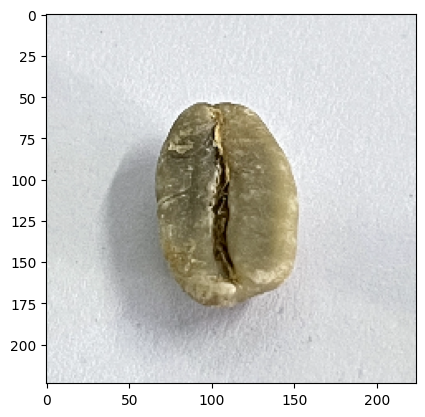

In [22]:
plt.imshow(np.clip((test_dataset[1]).cpu().numpy().transpose(1, 2, 0), 0, 1))

In [12]:
torch.save(resnet, "resnet18_v2.pth")

In [13]:
vit = models.vit_b_16(pretrained=True)
vit.heads = nn.Linear(vit.heads[0].in_features, 4)
train(vit, "ViT-B_16", 5)
eval(vit, "ViT-B_16")

c:\Users\Aila\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Aila\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ViT-B_16: epoch #1, loss: 1.2270
ViT-B_16: epoch #2, loss: 0.6779
ViT-B_16: epoch #3, loss: 0.2837
ViT-B_16: epoch #4, loss: 0.2071
ViT-B_16: epoch #5, loss: 0.1863

Evaluation Metrics for ViT-B_16:
Accuracy: 0.975
Precision: 0.9752891755521707
Recall: 0.975
F1 Score: 0.9749409138889937
[3, 1, 2, 2, 1, 3, 0, 2, 2, 3, 1, 2, 2, 0, 0, 2, 0, 3, 0, 1, 3, 0, 2, 0, 2, 1, 2, 2, 2, 0]
[3, 1, 2, 2, 1, 3, 0, 2, 2, 3, 1, 2, 2, 0, 0, 2, 0, 3, 0, 1, 3, 0, 2, 0, 2, 1, 2, 2, 2, 0]


In [23]:
torch.save(vit, "vit16_v1.pth")

Оценим работу классификатора

Вывод:
1. Метрики для ResNet18:
Модель показывает крайне нестабильное поведение: высокая precision при низких recall и F1 говорит о том, что ResNet18 уверенно классифицирует 2 из 4 классов, игнорируя другие. Это может свидетельствовать о переобучении на части данных. Несмотря на длительное обучение (15 эпох), модель не смогла обобщить знания для всей выборки.
2. Метрики для ViT-B16:
ViT показал отличные результаты по всем метрикам — высокая согласованность между precision, recall и F1 указывает на качественную и стабильную классификацию всех классов. Даже при меньшем количестве эпох ViT лучше обучился на признаках изображений, что говорит о высокой способности к обобщению.

По итогу ResNet18 склонен к переобучению на отдельных классах и требует дополнительной настройки: возможно, нужно добавить аугментации или изменить архитектуру. ViT-B 16 — мощный трансформер, который даже при коротком обучении показывает отличное качество, и подходит лучше для данной задачи.

# Улучшение бейзлайна

Для улучшения бейзлайна модели в задачи классификации предлагаю следующие решения:

Провести аугментацию тренировочных данных: использовать нормализацию, повороты и изменить яркость и контраст изображений, а также заменить оптимизатор на AdamW.

Аугментация тренировочного датасета:

In [ ]:
aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

aug_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset_new = ImageFolder(root='./Coffee_bean_dataset/train', transform=aug_transform)
test_dataset_new = ImageFolder(root='./Coffee_bean_dataset/test', transform=aug_test_transform)

# Получаем случайно перемешанные индексы
indices_train_new = torch.randperm(len(train_dataset_new)).tolist()
indices_test_new = torch.randperm(len(test_dataset_new)).tolist()

# Создаём новое подмножество с перемешанным порядком
train_dataset_new = Subset(train_dataset_new, indices_train_new)
test_dataset_new = Subset(test_dataset_new, indices_test_new)

train_labels_new = [label for _, label in train_dataset_new]
train_dataset_new = [image for image, _ in train_dataset_new]
test_labels_new = [label for _, label in test_dataset_new]
test_dataset_new = [image for image, _ in test_dataset_new]

Теперь изменим методику обучения:

In [25]:
import copy

In [ ]:
def train_new(model, model_name, num_of_epochs=5):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

    best_loss = float('inf')
    patience = 5
    counter = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # Обучение
    for epoch in range(num_of_epochs):
        model.train()
        total_loss = 0.0
        for i in range (0, len(train_dataset_new)):
            image = train_dataset_new[i].to(device)
            label = torch.tensor(train_labels_new[i]).to(device)
            #image, label = image.to(device), label.to(device)

            optimizer.zero_grad()
            output = model(image.unsqueeze(0))
            loss = criterion(output, label.unsqueeze(0))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        #print(f"{model_name}: epoch #{epoch+1}, loss: {total_loss / len(train_dataset):.4f}")
        avg_train_loss = total_loss / len(train_dataset_new)
        
        # Валидация
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i in range (0, len(test_dataset_new)):
                image = test_dataset_new[i].to(device)
                label = torch.tensor(test_labels_new[i]).to(device)
                output = model(image.unsqueeze(0))
                loss = criterion(output, label.unsqueeze(0))
                val_loss += loss.item()
        avg_val_loss = val_loss / len(test_dataset_new)

        print(f"{model_name}: epoch #{epoch+1}: train loss: {avg_train_loss:.4f}, test loss: {avg_val_loss:.4f}")
        #scheduler.step(avg_val_loss)

        # Early stopping logic
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break
            
    # Load best model
    model.load_state_dict(best_model_wts)

In [50]:
resnet = torch.load("resnet18_v3_2.pth", weights_only=False)

#resnet = models.resnet18(pretrained=True)
#resnet.fc = nn.Linear(resnet.fc.in_features, 4) # 4 classes
resnet.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(resnet.layer4[1].conv2.out_channels, 4)
        )
train_new(resnet, "ResNet18", 3)
eval(resnet, "ResNet18")

ResNet18: epoch #1: train loss: 0.1129, test loss: 0.8159
ResNet18: epoch #2: train loss: 0.0084, test loss: 0.8612
ResNet18: epoch #3: train loss: 0.0036, test loss: 0.8130

Evaluation Metrics for ResNet18:
Accuracy: 0.89
Precision: 0.9037117117117117
Recall: 0.8899999999999999
F1 Score: 0.8882916885283973
[0, 1, 1, 1, 3, 1, 1, 0, 2, 2, 2, 2, 0, 2, 0, 3, 0, 2, 0, 3, 0, 0, 3, 1, 2, 3, 3, 2, 3, 0]
[0, 1, 1, 1, 0, 1, 2, 0, 2, 2, 2, 2, 0, 2, 0, 3, 0, 2, 3, 3, 0, 0, 0, 1, 2, 3, 3, 2, 3, 0]


In [51]:
torch.save(resnet, "resnet18_v3_3.pth")

In [54]:
vit = models.vit_b_16(pretrained=True)
vit.heads = nn.Linear(vit.heads[0].in_features, 4)
train_new(vit, "ViT-B_16", 2)
eval(vit, "ViT-B_16")

ViT-B_16: epoch #1: train loss: 0.7274, test loss: 0.5013
ViT-B_16: epoch #2: train loss: 0.2946, test loss: 0.0882

Evaluation Metrics for ViT-B_16:
Accuracy: 0.97
Precision: 0.9715327029156816
Recall: 0.97
F1 Score: 0.9701650726135262
[0, 1, 1, 1, 3, 1, 1, 0, 2, 2, 2, 2, 0, 2, 0, 3, 0, 2, 0, 3, 0, 0, 3, 1, 2, 3, 3, 2, 3, 0]
[0, 1, 1, 1, 3, 1, 1, 0, 2, 2, 2, 2, 0, 3, 0, 3, 0, 2, 3, 3, 0, 3, 3, 1, 2, 3, 3, 2, 3, 0]


In [55]:
torch.save(vit, "vit16_v3_1.pth")

Вывод:

После внесения улучшений в модель ResNet18 (добавление Dropout, применение аугментаций и подбор гиперпараметров) качество классификации значительно повысилось. F1-метрика увеличилась с 0.39 до 0.89, что говорит о резком улучшении сбалансированности между точностью и полнотой. Accuracy также выросла с 0.515 до 0.89, что свидетельствует о лучшей способности модели распознавать все классы.

Модель ViT-B/16, обученная на улучшенном пайплайне, достигла таких же высоких результатов при уменьшенном количестве эпох: F1-метрика составила 0.97, а Accuracy — 0.97, что говорит о практически безошибочной классификации.

Таким образом, улучшения в виде аугментаций, подбора гиперпараметров и архитектурных изменений оказали положительное влияние на обе модели.
Модель ResNet18 значительно повысила свою эффективность, а ViT-B/16 с минимальным числом эпох обучения достигла почти идеальных метрик, демонстрируя превосходную способность к обобщению. Улучшенные модели стали более точными, уверенными и устойчивыми к переобучению.

### Имплементация алгоритма

In [64]:
import torch.nn as nn
import math

In [77]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        identity = x if self.downsample is None else self.downsample(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + identity)

class CustomResNet18(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = [BasicBlock(in_channels, out_channels, stride, downsample)]
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


In [78]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, emb_size=768):
        super().__init__()
        self.n_patches = (img_size // patch_size) ** 2
        self.patch_proj = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.patch_proj(x)  # (B, E, H/P, W/P)
        x = x.flatten(2)        # (B, E, N)
        x = x.transpose(1, 2)   # (B, N, E)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size=256, num_heads=8, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=emb_size, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(emb_size)

    def forward(self, x):
        residual = x
        x, _ = self.attn(x, x, x)
        return self.norm(x + residual)

class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_size=256, num_heads=8, mlp_dim=512, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(emb_size, num_heads, dropout)
        self.norm = nn.LayerNorm(emb_size)
        self.mlp = nn.Sequential(
            nn.Linear(emb_size, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, emb_size),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        x = self.attn(x)
        return self.norm(x + self.mlp(x))

class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, emb_size=768, depth=12,
                 num_heads=12, mlp_dim=3072, num_classes=4):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, emb_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.pos_embed = nn.Parameter(torch.randn(1, (img_size // patch_size)**2 + 1, emb_size))
        self.encoder = nn.Sequential(*[
            TransformerEncoderBlock(emb_size, num_heads, mlp_dim)
            for _ in range(depth)
        ])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, num_classes)
        )

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)  # (B, N, E)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, E)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, N+1, E)
        x = x + self.pos_embed
        x = self.encoder(x)
        return self.mlp_head(x[:, 0])  # Use [CLS] token


Посмотрим работу имплементированного алгоритма на обычном датасете:

In [79]:
implemented_resnet = CustomResNet18(num_classes=4).to(device)
train(implemented_resnet, "Implemented ResNet18", 5)
eval(implemented_resnet, "Implemented ResNet18")

Implemented ResNet18: epoch #1, loss: 0.7390
Implemented ResNet18: epoch #2, loss: 0.3300
Implemented ResNet18: epoch #3, loss: 0.2190
Implemented ResNet18: epoch #4, loss: 0.1479
Implemented ResNet18: epoch #5, loss: 0.1609

Evaluation Metrics for Implemented ResNet18:
Accuracy: 0.6375
Precision: 0.5376344086021505
Recall: 0.6375
F1 Score: 0.551466049382716
[3, 0, 0, 0, 2, 3, 2, 3, 3, 2, 1, 1, 0, 2, 2, 2, 0, 1, 0, 3, 2, 1, 1, 3, 2, 2, 0, 3, 1, 0]
[3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 1, 1, 3, 2, 2, 3, 3, 1, 3]


c:\Users\Aila\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [80]:
torch.save(implemented_resnet, "resnet18_v5_1.pth")

In [81]:
immplemented_vit = VisionTransformer(num_classes=4).to(device)
train(immplemented_vit, "Implemented ViT-B_16", 5)
eval(immplemented_vit, "Implemented ViT-B_16")

Implemented ViT-B_16: epoch #1, loss: 1.5583
Implemented ViT-B_16: epoch #2, loss: 1.4390
Implemented ViT-B_16: epoch #3, loss: 1.4262
Implemented ViT-B_16: epoch #4, loss: 1.4174
Implemented ViT-B_16: epoch #5, loss: 1.4124

Evaluation Metrics for Implemented ViT-B_16:
Accuracy: 0.25
Precision: 0.0625
Recall: 0.25
F1 Score: 0.1
[3, 0, 0, 0, 2, 3, 2, 3, 3, 2, 1, 1, 0, 2, 2, 2, 0, 1, 0, 3, 2, 1, 1, 3, 2, 2, 0, 3, 1, 0]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


c:\Users\Aila\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [82]:
torch.save(immplemented_vit, "vit16_v5_1.pth")

А теперь проверим на улучшенном бейзлайне:

In [ ]:
implemented_resnet_new = CustomResNet18(num_classes=4).to(device)
train_new(implemented_resnet_new, "Implemented ResNet18", 3)
eval(implemented_resnet_new, "Implemented ResNet18")

Implemented ResNet18: epoch #1: train loss: 0.0977, test loss: 1.3991
Implemented ResNet18: epoch #2: train loss: 0.0987, test loss: 1.0964
Implemented ResNet18: epoch #3: train loss: 0.1289, test loss: 0.8849

Evaluation Metrics for Implemented ResNet18:
Accuracy: 0.54
Precision: 0.6252326048653828
Recall: 0.54
F1 Score: 0.5217380412231344
[0, 1, 1, 1, 3, 1, 1, 0, 2, 2, 2, 2, 0, 2, 0, 3, 0, 2, 0, 3, 0, 0, 3, 1, 2, 3, 3, 2, 3, 0]
[0, 2, 2, 1, 3, 1, 2, 3, 2, 2, 2, 2, 3, 2, 0, 3, 3, 2, 3, 3, 0, 3, 2, 2, 2, 2, 3, 2, 3, 3]


In [ ]:
torch.save(implemented_resnet_new, "resnet18_v4_2.pth")

In [ ]:
immplemented_vit_new = VisionTransformer(num_classes=4).to(device)
train_new(immplemented_vit_new, "Implemented ViT-B_16", 5)
eval(immplemented_vit_new, "Implemented ViT-B_16")

Implemented ViT-B_16: epoch #1: train loss: 1.5670, test loss: 1.5546
Implemented ViT-B_16: epoch #2: train loss: 1.4362, test loss: 1.5112
Implemented ViT-B_16: epoch #3: train loss: 1.4166, test loss: 1.4906
Implemented ViT-B_16: epoch #4: train loss: 1.4112, test loss: 1.4753
Implemented ViT-B_16: epoch #5: train loss: 1.4050, test loss: 1.4588

Evaluation Metrics for Implemented ViT-B_16:
Accuracy: 0.25
Precision: 0.0625
Recall: 0.25
F1 Score: 0.1
[0, 1, 1, 1, 3, 1, 1, 0, 2, 2, 2, 2, 0, 2, 0, 3, 0, 2, 0, 3, 0, 0, 3, 1, 2, 3, 3, 2, 3, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


c:\Users\Aila\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
torch.save(immplemented_vit_new, "vit16_v4_1.pth")

##### Сравнение собственной реализации ResNet и Vision Transformer до улучшения бейзлайна:
Собственная реализация ResNet показывает более высокое качество классификации по сравнению с Vision Transformer. На тестовой выборке Accuracy у ResNet составляет 0.6375 против 0.25 у ViT, а F1-мера — 0.5515 против 0.1. Это говорит о том, что ViT без предобученных весов не справляется с задачей классификации и выдает один и тот же класс. ResNet демонстрирует устойчивое обучение и адекватные метрики.


##### Сравнение собственной реализации ResNet и Vision Transformer после улучшения бейзлайна:
После улучшения бейзлайна производительность ResNet немного снизилась (Accuracy: 0.54, F1: 0.5217), но осталась на приемлемом уровне. В то же время ViT снова показывает крайне низкие результаты: Accuracy = 0.25 и F1 = 0.1, предсказывая только один класс вне зависимости от входного изображения. Это указывает на то, что без предобученных весов и соответствующей настройки архитектуры ViT не обучается эффективно.

### Вывод:
Улучшение бейзлайна не дало положительного эффекта для Vision Transformer — модель по-прежнему не обучается. Для ResNet метрики немного снизились, что может быть связано с небольщим переобучением, т. к. на улучшенном датасете ResNet обучался 9 эпох, в то время как на обычном - 5. В текущем виде ResNet значительно превосходит ViT, а последний требует доработки — в первую очередь, подключения предобученных весов и, возможно, настройки параметров архитектуры.